# Lab 2: Document Processing with PaddleOCR

In this lesson, you'll learn how OCR has evolved over time from Tesseract to PaddleOCR.

**Learning Objectives:**
- Use PaddleOCR for text detection and text recognition
- Identify PaddleOCR limitations on charts and multi-column layouts
- Use PaddleOCR for layout detection to identify regions of interest

## Background

Tesseract represents the traditional computer vision era. It uses hand-engineered features and procedural rules. PaddleOCR represents the modern deep learning era. It uses neural networks in two steps:

1. **Text Detection**: Locate all text regions in the image
2. **Text Recognition**: Decode the text content from each region

## Outline

- [1. PaddleOCR Basics](#1)
  - [1.1. Create the PaddleOCR Tool](#1-1)
  - [1.2. Create & Run the Agent](#1-2)
  - [1.3. Run PaddleOCR on Table and Handwriting Examples](#1-3)
- [2. PaddleOCR Limitations](#2)
- [3. PaddleOCR Layout Detection](#3)
- [4. More Complex Layout](#4)

## Setup

Import the packages for the OCR pipeline:
- **Pillow** for image loading
- **OpenCV** for image processing
- **PaddleOCR** for parsing documents

In [27]:
import os
from pathlib import Path
from typing import List, Dict, Any

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.agents import create_tool_calling_agent
from langchain.agents import AgentExecutor

from langchain_openai import ChatOpenAI

from PIL import Image
import cv2

os.environ['DISABLE_MODEL_SOURCE_CHECK'] = 'True'
from paddleocr import PaddleOCR

In [28]:
from dotenv import load_dotenv

# Load environment variables from .env
_ = load_dotenv(override=True)

<a id="1"></a>

## 1. PaddleOCR Basics

Initialize PaddleOCR with English language support. This loads two models:
- **_DET**: Text detection model (locates text regions)
- **_REC**: Text recognition model (reads characters)

PaddleOCR handles preprocessing and orchestrates both models automatically.

<p style="background-color:#fff6e4; padding:15px; border-width:3px; border-color:#f5ecda; border-style:solid; border-radius:6px"> ⏳ <b>Note <code>(Model Download)</code>:</b> We must download both models for PaddleOCR. Be aware that the downloads will take a moment. Subsequently, the models will load from cached files in the `.paddlex` folder.

In [29]:
# Initialize English OCR model
ocr = PaddleOCR(lang='en')

Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/home/jovyan/.paddlex/official_models/PP-LCNet_x1_0_doc_ori`.
Creating model: ('UVDoc', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/home/jovyan/.paddlex/official_models/UVDoc`.
Creating model: ('PP-LCNet_x1_0_textline_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/home/jovyan/.paddlex/official_models/PP-LCNet_x1_0_textline_ori`.
Creating model: ('PP-OCRv5_server_det', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/home/jovyan/.paddlex/official_models/PP-OCRv5_server_det`.
Creating model: ('en_PP-OCRv5_mobile_rec', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/home/jovyan/.paddlex/official_m

This receipt from Lesson 1 will show how PaddleOCR compares to Tesseract.

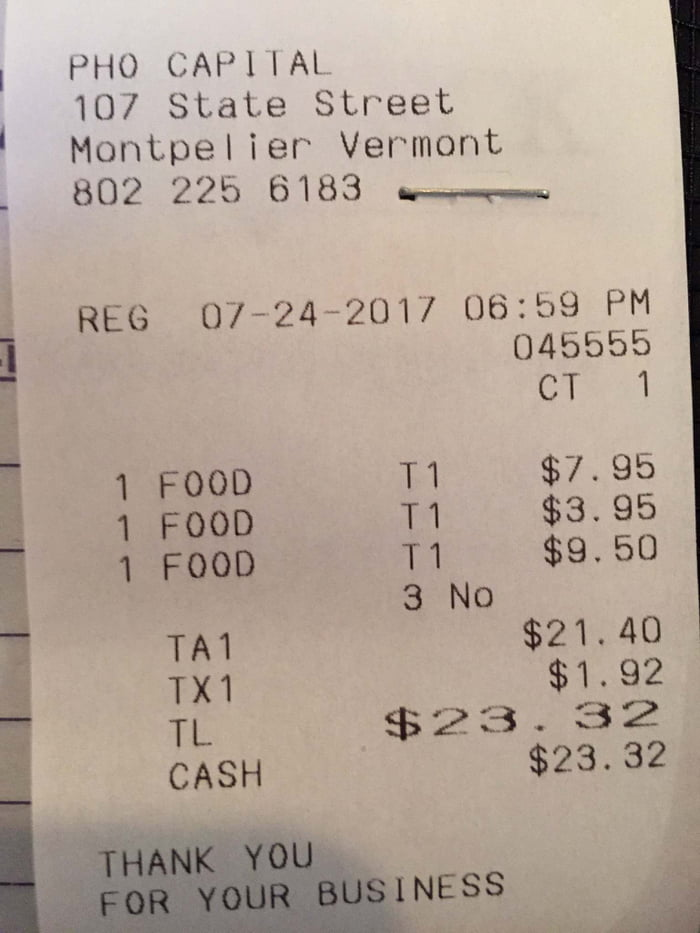

In [30]:
image_path = 'receipt.jpg'
img = Image.open(image_path)
display(img)

Run OCR on the image. The result contains one page-level dictionary for single-page images.

In [31]:
# Run OCR
result = ocr.predict(image_path)

Print the OCR results containing:
- **Recognized text** strings
- **Confidence scores** for each line
- **Bounding box coordinates** (localization information)

Note two improvements over Tesseract: (1) bounding boxes showing where each text appears, and (2) correct reading of \\$7.95. Previously, Tesseract misread this as \\$7.99).

In [32]:
page = result[0]
texts = page['rec_texts'] # recognized text strings
scores = page['rec_scores'] # confidence scores for each text line
boxes  = page['rec_polys'] #  bounding box coordinates

for text, score, box in zip(texts, scores, boxes):
    # box is a numpy array like [[x1, y1], [x2, y2], [x3, y3], [x4, y4]]
    coords = box.astype(int).tolist()  # convert to normal list of ints
    print(f"{text:25} | {score:.3f} | {coords}")

PHO CAPITAL               | 0.995 | [[57, 3], [336, 0], [336, 39], [58, 44]]
107 State Street          | 0.998 | [[62, 49], [461, 43], [462, 84], [63, 91]]
Montpelier Vermont        | 0.996 | [[58, 94], [512, 89], [512, 134], [58, 138]]
802 225 6183              | 0.969 | [[59, 142], [362, 140], [362, 178], [59, 180]]
REG                       | 0.998 | [[55, 271], [142, 268], [143, 306], [56, 309]]
07-24-2017 06:59 PM       | 0.993 | [[182, 268], [668, 263], [668, 305], [182, 309]]
045555                    | 0.999 | [[511, 309], [667, 306], [667, 345], [511, 347]]
CT 1                      | 0.953 | [[534, 347], [671, 345], [671, 392], [535, 394]]
FOOD                      | 0.996 | [[128, 444], [242, 441], [243, 484], [129, 487]]
T1                        | 0.995 | [[384, 439], [438, 437], [440, 480], [386, 482]]
$7.95                     | 0.999 | [[537, 436], [668, 433], [668, 476], [537, 479]]
1                         | 0.987 | [[90, 450], [111, 448], [114, 480], [93, 482]]
T1  

PaddleOCR preprocesses images automatically—correcting rotation, deskewing, and removing noise.

In [33]:
img = page['doc_preprocessor_res']['output_img']

The visualization below shows the preprocessed image with bounding boxes and recognized text. Compare to the original: the background is cleaner and the image is slightly rotated for better alignment.

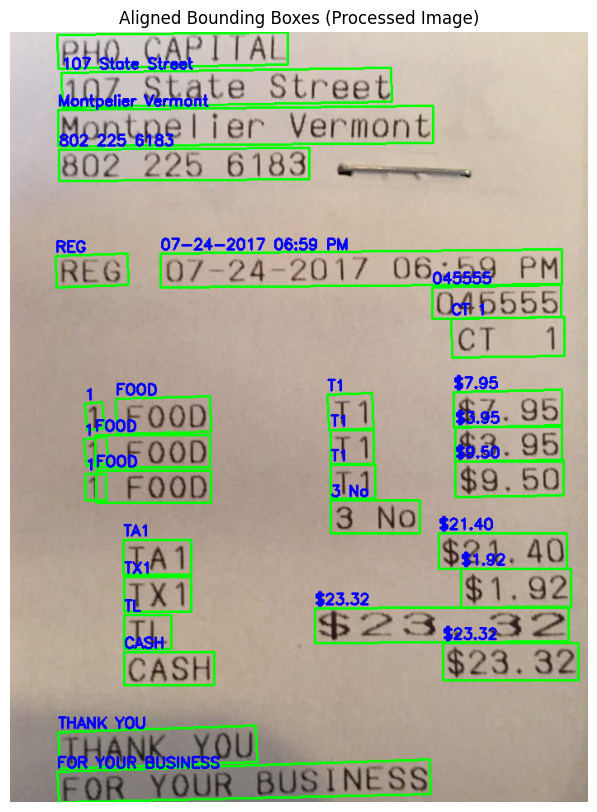

In [34]:
img_plot = img.copy()

for text, box in zip(texts, boxes):
    pts = np.array(box, dtype=int)
    cv2.polylines(img_plot, [pts], True, (0, 255, 0), 2)
    x, y = pts[0]
    cv2.putText(img_plot, text, (x, y - 5), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

plt.figure(figsize=(8, 10))
plt.imshow(cv2.cvtColor(img_plot, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Aligned Bounding Boxes (Processed Image)")
plt.show()

<a id="1-1"></a>

### 1.1. Create the PaddleOCR Tool

Convert PaddleOCR into a LangChain tool (similar to Lesson 1). The tool returns text, bounding boxes, and confidence scores.

In [35]:
from langchain.tools import tool

@tool
def paddle_ocr_read_document(image_path: str) -> List[Dict[str, Any]]:
    """
    Reads an image from the given path and returns extracted text 
    with bounding boxes.
    
    Returns a list of dictionaries, each containing:
    - 'text': the recognized text string
    - 'bbox': bounding box coordinates [x_min, y_min, x_max, y_max]
    - 'confidence': recognition confidence score (if available)
    """
    try:
        result = ocr.predict(image_path)
        page = result[0]
        
        texts = page['rec_texts'] 
        boxes = page['dt_polys']         
        scores = page.get('rec_scores', [None] * len(texts))  
        
        extracted_items = []
        for text, box, score in zip(texts, boxes, scores):
            x_coords = [point[0] for point in box]
            y_coords = [point[1] for point in box]
            bbox = [min(x_coords), min(y_coords), max(x_coords), 
                    max(y_coords)]
            
            item = {
                'text': text,
                'bbox': bbox,
            }
            if score is not None:
                item['confidence'] = score
                
            extracted_items.append(item)
        
        return extracted_items
    
    except Exception as e:
        return [{"error": f"Error reading image: {e}"}]

<a id="1-2"></a>

### 1.2. Create & Run the Agent

Configure the agent with PaddleOCR as its tool. 

In [36]:
# 1. Define the list of tools
tools = [paddle_ocr_read_document]

# 2. Set up the OpenAI GPT model
llm = ChatOpenAI(
    model="gpt-5-mini", 
    temperature=1 
)

# 3. Create the OpenAI-compatible prompt
prompt = ChatPromptTemplate.from_messages([
    (
        "system",
        "You are a helpful assistant designed to extract information "+
        "from documents. "
            "You have access to this tool: "
            "Paddle OCR tool to extract raw texts, bounding boxes for "+
            "each text and confidence score from images "
        ),
        ("user", "{input}"),
        MessagesPlaceholder(variable_name="agent_scratchpad"),
    ]
)

# 4. Create a proper tool-calling agent
agent = create_tool_calling_agent(llm, tools, prompt)

# 5. Set up the AgentExecutor to run the tool-enabled loop
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)

Verify the receipt total. The turquoise output shows PaddleOCR results, and the green output shows LLM reasoning.

<p style="background-color:#f7fff8; padding:15px; border-width:3px; border-color:#e0f0e0; border-style:solid; border-radius:6px"> 🚨
&nbsp; <b>Different Run Results:</b> The output generated by AI can vary with each execution due to their non-deterministic nature. Don't be surprised if your results differ slightly from those shown in the video.</p>

With correct OCR inputs (unlike Tesseract's misreads), the total verification succeeds.

In [37]:
task = """
Process the document at 'receipt.jpg' and evaluate that 
the total is correct.
"""
response = agent_executor.invoke({"input": task})



> Entering new AgentExecutor chain...

Invoking: `paddle_ocr_read_document` with `{'image_path': 'receipt.jpg'}`


[{'text': 'PHO CAPITAL', 'bbox': [np.int16(57), np.int16(0), np.int16(336), np.int16(44)], 'confidence': 0.9953657388687134}, {'text': '107 State Street', 'bbox': [np.int16(62), np.int16(43), np.int16(462), np.int16(91)], 'confidence': 0.997774600982666}, {'text': 'Montpelier Vermont', 'bbox': [np.int16(58), np.int16(89), np.int16(512), np.int16(138)], 'confidence': 0.9964373111724854}, {'text': '802 225 6183', 'bbox': [np.int16(59), np.int16(140), np.int16(362), np.int16(180)], 'confidence': 0.9688597321510315}, {'text': 'REG', 'bbox': [np.int16(55), np.int16(268), np.int16(143), np.int16(309)], 'confidence': 0.9984455704689026}, {'text': '07-24-2017 06:59 PM', 'bbox': [np.int16(182), np.int16(263), np.int16(668), np.int16(309)], 'confidence': 0.9929590821266174}, {'text': '045555', 'bbox': [np.int16(511), np.int16(306), np.int16(667), np.int16(347)], 'confidence': 0.99

This demonstrates how accurate OCR (PaddleOCR) combined with LLM reasoning produces correct results.

<a id="1-3"></a>

### 1.3. Run PaddleOCR on the Table and Handwriting Examples

Test PaddleOCR on the table and handwriting examples from Lesson 1.

This helper function runs OCR and visualizes results with bounding boxes.

In [38]:
def run_ocr(image_path, ocr_model = ocr, show_text = True):

    display(Image.open(image_path))
    result = ocr.predict(image_path)
    
    page = result[0]
    texts  = page['rec_texts'] 
    scores = page['rec_scores'] 
    boxes  = page['rec_polys'] 
    
    for text, score, box in zip(texts, scores, boxes):
        coords = box.astype(int).tolist()  
        print(f"{text:25} | {score:.3f} | {coords}")
        
    img = page['doc_preprocessor_res']['output_img'] 
    img_plot = img.copy()

    image_path = Path(image_path)
    output_path = image_path.with_stem(image_path.stem + "_output")  
    cv2.imwrite(str(output_path), img)
    
    for text, box in zip(texts, boxes):
        pts = np.array(box, dtype=int)
        cv2.polylines(img_plot, [pts], True, (0, 255, 0), 2)
        x, y = pts[0]
        if show_text:
            cv2.putText(img_plot, text, 
                        (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 
                        0.6, (255, 0, 0), 2)
    
    plt.figure(figsize=(8, 10))  
    plt.imshow(cv2.cvtColor(img_plot, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title("Aligned Bounding Boxes (Processed Image)")
    plt.show()

#### Table Example

Inspect the output for errors. Notice exponential notation issues—`10^20` may be read as `1020`. This affects both PaddleOCR and Tesseract.

In [ ]:
run_ocr("table.png")

Extract FLOPs from the EN-DE column. Notice:
- **ByteNet** and **Deep-Att** correctly marked as "not found" (blank cells)
- Scientific notation corrected (e.g., `1020` → `10^20`)

This demonstrates LLM reasoning—recognizing that FLOPs (floating point operations) must be large numbers, not small integers like 1020.

In [ ]:
task = """
Extract the Training Cost (FLOPs) for EN-DE for ALL methods from 
the table.png using the OCR tool.
Return as a list with model name and its training cost.
"""

response = agent_executor.invoke({"input": task})

# Display results side by side
print("\n" + "─"*35 + " LLM RESULT " + "─"*33)
print("="*80)
print(response["output"])
print("="*80)

#### Handwriting Example

Test PaddleOCR on student handwriting. 

In [ ]:
run_ocr("handwritten.jpg")

The prompt instructs the agent not to correct grammatical errors, preserving the student's original answers.

In [ ]:
task = """
Please process the document at 'handwritten.jpg' using ocr 
and extract the following information in JSON format:
- `student name`
- `student answer to all the ten questions`
Do not correct any grammatical errors.
"""

response = agent_executor.invoke({"input": task})

print("\n" + "─"*35 + " LLM RESULT " + "─"*33)
print(response["output"])
print("="*80)

Note that grammatical error were preserved in results. For example, Question 9 has "is" instead of "are".

<a id="2"></a>

## 2. PaddleOCR Limitations

PaddleOCR had few errors than Tesseract. However handwriting remained challenging. Let's test PaddleOCR on other challenging cases to expose its limitations.

### Charts and Figures

This `report.png` document contains a table (top), text (center), and a **line chart** with caption (bottom).

In [ ]:
run_ocr("report.png", show_text=False)

PaddleOCR did not recognize the chart as a region. Note the lack of a bounding box around it. While PaddleOCR detected labels on axes, there is no context for these label. For example, horizontal axis versus vertical axis. 

### Multi-Column Layouts

This `article.jpg` shows a typical academic article with multiple columns, an abstract, callout boxes, and tables.

In [ ]:
run_ocr("article.jpg", show_text=False)

PaddleOCR reads straight across all columns as opposed to down the left column, then the next column.

For example "in most of the Westernized countries that undertake..." becomes "in most of the Westernized countries system based on some of the interview..."

This produces garbled text in multi-column layouts.

<a id="3"></a>

## 3. PaddleOCR Layout Detection

PaddleOCR includes a layout detection module that identifies document regions (footer, tables, charts, etc) before text extraction.

In [ ]:
from paddleocr import LayoutDetection

In [ ]:
layout_engine = LayoutDetection()

This function processes images with the layout engine, returning:
- **label**: Region type (text, chart, table, etc.)
- **score**: Confidence score
- **bbox**: Bounding box coordinates

In [ ]:
def process_document(image_path):
    # Get layout regions
    layout_result = layout_engine.predict(image_path)
    
    # Parse the boxes
    regions = []
    for box in layout_result[0]['boxes']:
        regions.append({
            'label': box['label'],
            'score': box['score'],
            'bbox': box['coordinate'],  # [x1, y1, x2, y2]
        })
    
    # Sort by confidence
    regions = sorted(regions, key=lambda x: x['score'], reverse=True)
    
    return regions

Apply layout detection to the economic report. The labels identify region types: **text**, **chart**, **paragraph_title**, **table**, **footer**, etc.

In [ ]:
regions = process_document("report.png")

for r in regions:
    print(f"{r['label']:20} score: {r['score']:.3f}  bbox: {[int(x) for x in r['bbox']]}")

Visualize layout detection results with color-coded bounding boxes for each region type.

In [ ]:
def visualize_layout(image_path, min_confidence=0.5):
    
    layout_result = layout_engine.predict(image_path)
    
    img = cv2.imread(image_path)
    img_plot = img.copy()
    
    # Get all unique labels
    labels = list(set(box['label'] for box in layout_result[0]['boxes']))
    
    # Generate colors dynamically from colormap
    cmap = colormaps.get_cmap('tab20') 
    color_map = {}
    for i, label in enumerate(labels):
        rgba = cmap(i % 20)
        # Convert to BGR (0-255) for OpenCV
        color_map[label] = (int(rgba[2]*255), int(rgba[1]*255), int(rgba[0]*255))
    
    for box in layout_result[0]['boxes']:
        if box['score'] < min_confidence:
            continue
            
        label = box['label']
        score = box['score']
        coords = box['coordinate']
        
        color = color_map[label]
        
        x1, y1, x2, y2 = [int(c) for c in coords]
        pts = np.array([[x1, y1], [x2, y1], [x2, y2], [x1, y2]], dtype=int)
        
        cv2.polylines(img_plot, [pts], True, color, 2)
        text = f"{label} ({score:.2f})"
        cv2.putText(img_plot, text, (x1, y1-8), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
    
    return img_plot

Visualize layout detection on the economic report. Notice:
- Multiple **text** blocks
- **Paragraph_title** and **table** regions
- **Chart** with a complete bounding box (not just axis labels)
- Small elements: **number** and **footer**

The layout model correctly identifies all major document regions.

In [ ]:
# Run visualization
result_image = visualize_layout("report.png", min_confidence=0.5)

# Display with matplotlib
plt.figure(figsize=(12, 14))
plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Layout Detection Results")
plt.show()

Apply layout detection to the multi-column article. Notice region labels:
- **text**, **paragraph_title**, **document_title**, **abstract**
- **footnote**, **footer**, **table**

Layout detection preserves column boundaries. Text blocks stay intact which prevents the reading order errors seen earlier.

In [ ]:
# Run visualization
result_image = visualize_layout("article.jpg", min_confidence=0.5)

# Display with matplotlib
plt.figure(figsize=(12, 14))
plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Layout Detection Results")
plt.show()

<a id="4"></a>

## 4. More Complex Layout

Test layout detection on a bank statement which requires extracting key-value pairs from complex tabular layouts.

- Table header detection accuracy
- Whether multiple tables are distinguished
- Small text (legal disclaimers) detection

In [ ]:
# Run visualization
result_image = visualize_layout("bank_statement.png", min_confidence=0.5)

# Display with matplotlib
plt.figure(figsize=(15, 20))
plt.imshow(result_image)
plt.axis('off')
plt.title('Layout Detection Results')
plt.tight_layout()
plt.show()

## Summary

Here's what we covered:

| Aspect | PaddleOCR | Tesseract |
|--------|-----------|----------|
| **Era** | Deep Learning | Traditional/Procedural |
| **Approach** | Neural networks | Hand-engineered rules |
| **Strength** | Real-world documents, irregular text | Clean printed text |
| **Output** | Text + bounding boxes + confidence scores | Text only |

The next lesson explores layout detection and reading order in depth to handle some of the key challenges around charts and tables. 
